# Financial Transaction Project

This project is about the process to create an unsupervised machine learning model to categorize credit card transactions to the appropriate budget categories based on previous transactions. The model could adapt and adjust its assignments as the user generates their own categories but in order to overcome the cold start problem, we can use the data from 'Financial Transactions Annotated with Intent and Expense Category.csv' to initialize the model. This data was taken from https://app.surgehq.ai/datasets/financial-transactions-intent-and-expense-category.

In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score

In [142]:
df = pd.read_csv('Financial Transactions Annotated with Intent and Expense Category.csv')
df.head()

,worker_id,task_id,task_response_id,transaction_text,transaction_value,transaction_type,transaction_description,Select the best category for this bank transaction
0,YYCA2DXN94NG,a9f6eed1-1c62-494e-8e06-787357e67e07,37927ba3-0504-4157-99ab-f3a687d912bf,8046 Debit Card Purchase Uber Help.Uber.Ca,4,Debit,This is a tip paid for an Uber ride.,Transportation / Taxis and ride shares
1,MFVVAY4H7Y4H,8c5c2797-544f-452e-b406-81784b36d741,d7577435-1ea4-48e4-ae7a-6f7047c2f8c0,UBER TRIP 8005928996 /CA US CARD PURCHASE,11.8,Debit,Uber trip from the hospital to my house.,Transportation / Public Transport
2,J6TM2D4MANTG,69332579-a566-4223-8f23-9fea43b44f87,35629ccf-9cb4-4945-9961-5fa176b0d2eb,DEBIT CARD PURCHASE XXXXX8046 LYFT *2 RIDES 04...,20.64,Debit,Rideshare charges for two rides.,"Rent & Utilities / Electricity, natural gas an..."
3,J6TM2D4MANTG,69332579-a566-4223-8f23-9fea43b44f87,fc10cc93-3953-4e6d-8859-9592b7d99bfc,DEBIT CARD PURCHASE XXXXX8046 LYFT *2 RIDES 04...,20.64,Debit,Rideshare charges for two rides.,Transportation / Taxis and ride shares
4,YYCA2DXN94NG,d16ee9b7-d5a0-4b19-9487-9cb12162cb91,42ee1332-0c26-4a7f-9ff2-666c35e52192,ENTERPRISE RENT A CAR E EGHAM,91.24,Debit,Car rental charge.,Travel / Rental cars


In [143]:
df.dropna(inplace=True)
df['category'] = df.apply(lambda x: x['Select the best category for this bank transaction\xa0'].split('/')[0].rstrip(), axis=1)
df.drop(columns=['worker_id', 'task_id', 'task_response_id', 'transaction_type', 'Select the best category for this bank transaction\xa0'], inplace=True)
df.head()

,transaction_text,transaction_value,transaction_description,category
0,8046 Debit Card Purchase Uber Help.Uber.Ca,4,This is a tip paid for an Uber ride.,Transportation
1,UBER TRIP 8005928996 /CA US CARD PURCHASE,11.8,Uber trip from the hospital to my house.,Transportation
2,DEBIT CARD PURCHASE XXXXX8046 LYFT *2 RIDES 04...,20.64,Rideshare charges for two rides.,Rent & Utilities
3,DEBIT CARD PURCHASE XXXXX8046 LYFT *2 RIDES 04...,20.64,Rideshare charges for two rides.,Transportation
4,ENTERPRISE RENT A CAR E EGHAM,91.24,Car rental charge.,Travel


In [144]:
df.category.unique()

array(['Transportation', 'Rent & Utilities', 'Travel', 'Loans', 'Medical',
       'Income', 'Government + Non-Profit', 'General Services',
       'General Merchandise', 'Food & Drink', 'Entertainment',
       'Bank Transfers'], dtype=object)

In [177]:
train, test = train_test_split(df, test_size=0.2)

In [179]:
test

,transaction_text,transaction_value,transaction_description,category
425,8382 Recurring Debit Card Www.Neopets.Com,24.95,Monthly membership for online gaming site.,Entertainment
165,Paypal Des: Transfer,86.12,Payment for writing work that I did.,Income
456,DEBIT AUTHORIZATION Jun15 03:42p 1459 AT 15:42...,3,Patreon membership.,Entertainment
213,TD ZELLE SENT 216400K00NGR Zelle SOLID ROCK COMM,20,Sent $20 via Zella to Solid Rock Community Chu...,Government + Non-Profit
303,DEBIT CARD PURCHASE XXXXX8046 MANDARIN BUFFET ...,23,Dinner at a Chinese buffet.,Food & Drink
...,...,...,...,...
159,TELUS INTERNATIO DES:REGEXPENSE ID: XXXXX81950...,73.16,Payment for freelancing work performed online.,Income
185,FLORIDA KID CARE B2P*FLORID 54899999,20.85,Health insurance payment.,General Services
295,PwP Scentbird N,3.21,This is a perfume subscription program.,General Merchandise
391,POS Withdrawal - DOORDASH*BIGFOOT JAVA 303 2nd...,17.19,I got some coffee from a coffee shop.,Food & Drink


(array([ 70.,   5.,  48.,  19.,  32.,  16.,  30.,  58., 138., 105.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

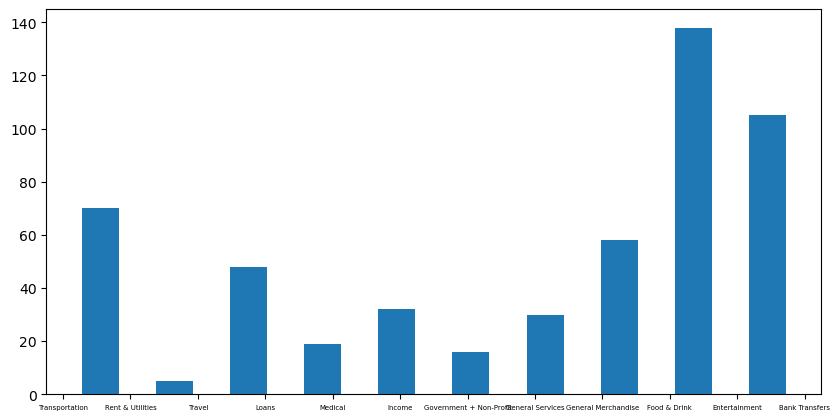

In [154]:
matplotlib.rc('xtick', labelsize=5)
plt.figure(figsize=(10,5))
plt.hist(df.category, rwidth=0.5)

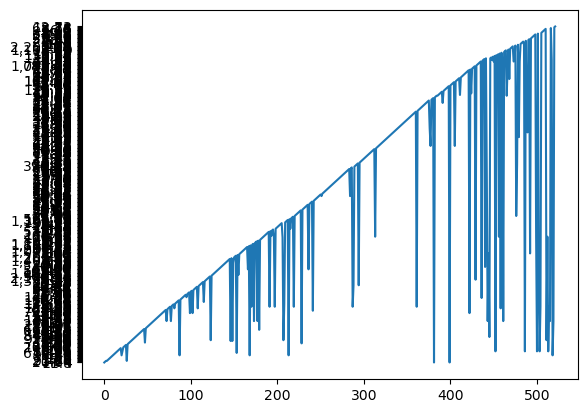

In [165]:
matplotlib.rc('xtick', labelsize=10)
plt.plot(df.transaction_value)

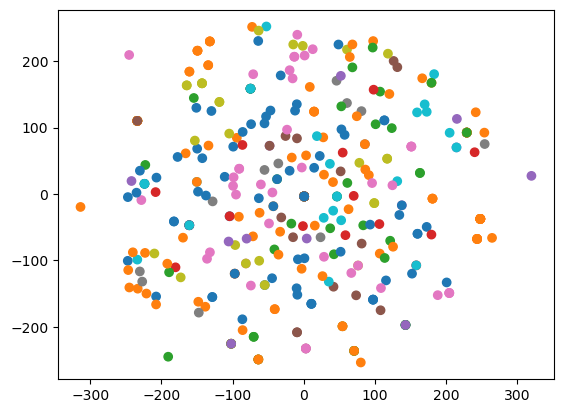

In [181]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(train.transaction_text).toarray()
labels = df.category

tsne = TSNE(n_components=2, random_state=11)
tsne = tsne.fit_transform(features)
plt.scatter(tsne[:, 0], tsne[:, 1], c=train.category.astype('category').cat.codes, cmap='tab10')
plt.show()

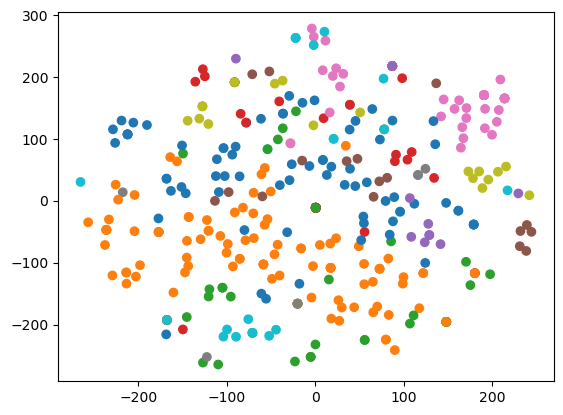

In [202]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(train.transaction_description).toarray()
labels = df.category

tsne = TSNE(n_components=2, random_state=11)
tsne = tsne.fit_transform(features)
plt.scatter(tsne[:, 0], tsne[:, 1], c=train.category.astype('category').cat.codes, cmap='tab10')
plt.show()

In [197]:
pd.DataFrame(features)

,0,1,2,3,4,5,6,7,8,9,...,66,67,68,69,70,71,72,73,74,75
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
def label_permute_compare(ytdf,yp):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    {3:'business', 4:'entertainment', 1:'politics', 2:'sport', 0:'tech'}, 0.74
    """
    y_true = np.array(ytdf).reshape(-1)
    uniq_labels = np.unique(y_true)
    perm = itertools.permutations(range(len(uniq_labels)))
    best_p, best_acc = None, 0
    for p in perm:
        p_label_map = {label: int_label for label, int_label in zip(uniq_labels, p)}
        p_labels = np.array([p_label_map[label] for label in y_true])
        acc = np.mean(p_labels == yp)
        if acc > best_acc:
            best_p = {num: l for num, l in zip(p, uniq_labels)}
            best_acc = acc
    return best_p, best_acc

nmf = NMF(n_components=train.category.nunique(), random_state=11)
nmf.fit(features)
y_pred = np.array([np.argmax(i) for i in nmf.transform(features)])
label_map, acc = label_permute_compare(train.category, y_pred)
#print("Train Accuracy:", acc)

KeyboardInterrupt: 

In [203]:
cluster = AgglomerativeClustering(n_clusters=11)
cluster.fit(features)

AgglomerativeClustering(n_clusters=11)

In [204]:
print(cluster.labels_)

[ 2  1  6  3  2  1  8  8  2 10  3  2  2  2  4  2 10  3  2  8  8  5  2  2
  7  2  8  2  2  3  2  2  2  9  5  2  2  5  3  6  8  2  2  2  2  8  0  8
  0  1  2  2  4  4  3  8  8  2  2  2  8  2  2  0  3  2  2  6  3  2  2  2
  2  1  6  2  2  2  1 10  1  3  2  0  2  2  0  2  5  4  1 10  2  2  3  4
  2  0  6  2  2  2  2  2  8  2  1  2  2  2  1  2  7  2  2  8  2  0  5  2
  2  2  0  2  1  3  8  2  2  8  2  2  1  2 10  7  1  2  1  8  2  2  0  4
  2  2  2  1  2  9  2  2  2  2  6  2  1  2  2  2  1  1 10  2  2  2  2  2
  8  7  2  0  3  2  2  5  3  2  3  2  4  3  1  7  2  8  8  0  0  2  3  2
  2  1  1  2  1  2  4  7  2  2  2  6  2  2  2  0  0  2  1  2  6  7  2  1
  2  5  2  2  1  6  1  3  2  1  2  2  1  2  5  2  2  3  2  8  1  2  2  3
  2  2  2  2  2  1  2  3  7  0  7  2  8  2  2  1  1  0  5  8  2  5  2  3
  7  2  2  2  2  2  2  3  2  9  3  2  2  0  2  2  2  2  1  1  2  2  2  2
  1  2  8  2  2  6  6  1  2  2 10  0  2  2  2  2  2  2  3  1  5  6  1  2
  2  2  2  2  9 10  2  2  2  2  2  2  2  2  1  2  2

In [214]:
labels = train.category.unique()
permutation = itertools.permutations(range(train.category.nunique()))

for p in permutation:
    p_label_map = {label: int_label for label, int_label in zip(labels, p)}
    break
print(p_label_map)

{'Food & Drink': 0, 'Bank Transfers': 1, 'General Merchandise': 2, 'Rent & Utilities': 3, 'Loans': 4, 'Entertainment': 5, 'Travel': 6, 'Transportation': 7, 'Income': 8, 'General Services': 9, 'Medical': 10, 'Government + Non-Profit': 11}


In [219]:
def label_permute_compare(ytdf,yp,n=11):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # your code here
    permutation = itertools.permutations(range(ytdf.category.nunique()))
    labels = ytdf.category.unique()
    best = []
    best_acc = 0
    for p in permutation:
        p_label_map = {int_label: label for int_label, label in zip(p, labels)}
        yt = ytdf.category
        for i in range(n):
            yt = yt.replace(labels[i], p_label_map[i])
        print(p_label_map)
        print(yp)
        acc = accuracy_score(yt, yp)
        if acc > best_acc:
            best = p
            best_acc = acc
    return best, best_acc

labelorder, acc = label_permute_compare(train, cluster.labels_)
print(labelorder, acc)

{0: 'Food & Drink', 1: 'Bank Transfers', 2: 'General Merchandise', 3: 'Rent & Utilities', 4: 'Loans', 5: 'Entertainment', 6: 'Travel', 7: 'Transportation', 8: 'Income', 9: 'General Services', 10: 'Medical', 11: 'Government + Non-Profit'}
[ 2  1  6  3  2  1  8  8  2 10  3  2  2  2  4  2 10  3  2  8  8  5  2  2
  7  2  8  2  2  3  2  2  2  9  5  2  2  5  3  6  8  2  2  2  2  8  0  8
  0  1  2  2  4  4  3  8  8  2  2  2  8  2  2  0  3  2  2  6  3  2  2  2
  2  1  6  2  2  2  1 10  1  3  2  0  2  2  0  2  5  4  1 10  2  2  3  4
  2  0  6  2  2  2  2  2  8  2  1  2  2  2  1  2  7  2  2  8  2  0  5  2
  2  2  0  2  1  3  8  2  2  8  2  2  1  2 10  7  1  2  1  8  2  2  0  4
  2  2  2  1  2  9  2  2  2  2  6  2  1  2  2  2  1  1 10  2  2  2  2  2
  8  7  2  0  3  2  2  5  3  2  3  2  4  3  1  7  2  8  8  0  0  2  3  2
  2  1  1  2  1  2  4  7  2  2  2  6  2  2  2  0  0  2  1  2  6  7  2  1
  2  5  2  2  1  6  1  3  2  1  2  2  1  2  5  2  2  3  2  8  1  2  2  3
  2  2  2  2  2  1  2  3  7  0  

KeyboardInterrupt: 

In [220]:
def label_permute_compare(ytdf,yp):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    {3:'business', 4:'entertainment', 1:'politics', 2:'sport', 0:'tech'}, 0.74
    """
    y_true = np.array(ytdf).reshape(-1)
    uniq_labels = np.unique(y_true)
    perm = itertools.permutations(range(len(uniq_labels)))
    best_p, best_acc = None, 0
    for p in perm:
        p_label_map = {label: int_label for label, int_label in zip(uniq_labels, p)}
        p_labels = np.array([p_label_map[label] for label in y_true])
        acc = np.mean(p_labels == yp)
        if acc > best_acc:
            best_p = {num: l for num, l in zip(p, uniq_labels)}
            best_acc = acc
    return best_p, best_acc

nmf = NMF(n_components=train.category.nunique(), random_state=11)
nmf.fit(features)
y_pred = np.array([np.argmax(i) for i in nmf.transform(features)])
label_map, acc = label_permute_compare(train.category, y_pred)
print("Train Accuracy:", acc)

KeyboardInterrupt: 